In [4]:
from pathlib import Path

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

DATA_PATH = Path("../../data")

In [5]:
rng = np.random.default_rng(seed=12)
az.style.use("arviz-white")

In [8]:
congress = pd.read_csv(DATA_PATH / "congress.csv")
congress.head()

,inc86,inc88,inc90,v86,v88,v90,v86_adj,v88_adj,v90_adj
0,1,1,1,0.745036,0.772443,0.714029,0.745036,0.772443,0.714029
1,1,1,1,0.673845,0.636182,0.597050,0.673845,0.636182,0.597050
2,1,1,0,0.696457,0.664928,0.521043,0.696457,0.664928,0.521043
3,-1,-1,-1,0.464590,0.273834,0.234377,0.464590,0.273834,0.234377
4,-1,-1,0,0.391095,0.263613,0.477439,0.391095,0.263613,0.477439


## Regression predicting 1988 from 1986

In [9]:
data88 = pd.DataFrame(
    dict(
        vote=congress["v88_adj"],
        past_vote=congress["v86_adj"],
        inc=congress["inc88"],
    )
)

In [10]:
model_88 = bmb.Model("vote ~ past_vote + inc", data=data88)
idata_88 = model_88.fit()
az.summary(idata_88, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vote_sigma, Intercept, inc, past_vote]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,0.238,0.017,0.204,0.269
past_vote,0.520,0.033,0.459,0.582
inc,0.097,0.007,0.084,0.109
vote_sigma,0.067,0.002,0.063,0.072


## Simulation for inferences and predictions of new data points
### Predict from 1988 to 1990

In [12]:
data90 = pd.DataFrame(
    dict(
        past_vote=congress["v88_adj"],
        inc=congress["inc90"],
    )
)

### Simulate predictive simulations of the vector of new outcomes

In [15]:
pred90 = model_88.predict(idata_88, data=data90, kind="pps", inplace=False)

### Simulate the number of elections predicted to be won by the Democrats in 1990

In [53]:
dems_pred = pred90.posterior_predictive["vote"].values.reshape(-1, 435)
dems_pred = (dems_pred > 0.5).sum(axis=1)

### Our posterior mean and sd of how many districts the Dems will win

In [62]:
print(f"mean: {dems_pred.mean():.1f}, std: {dems_pred.std():.1f}")

mean: 260.0, std: 2.5


### Histogram of how many districts the Dems will win

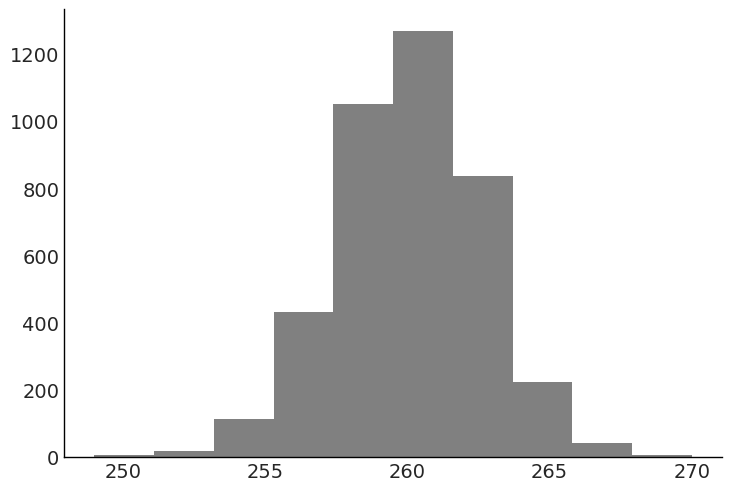

In [66]:
plt.hist(dems_pred, color="gray");

## Graphs

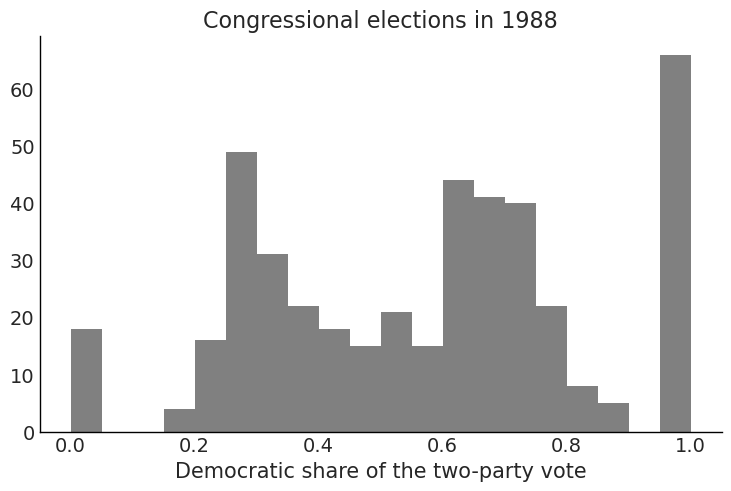

In [75]:
v88_hist = np.where(
    congress["v88"] < 0.1,
    0.0001,
    np.where(congress["v88"] > 0.9, 0.9999, congress["v88"]),
)

fig, ax = plt.subplots()
ax.hist(v88_hist, color="gray", bins=np.arange(0, 1.05, 0.05))
ax.set_xlabel("Democratic share of the two-party vote")
ax.set_title("Congressional elections in 1988");

Text(0, 0.5, 'Democratic vote share in 1988')

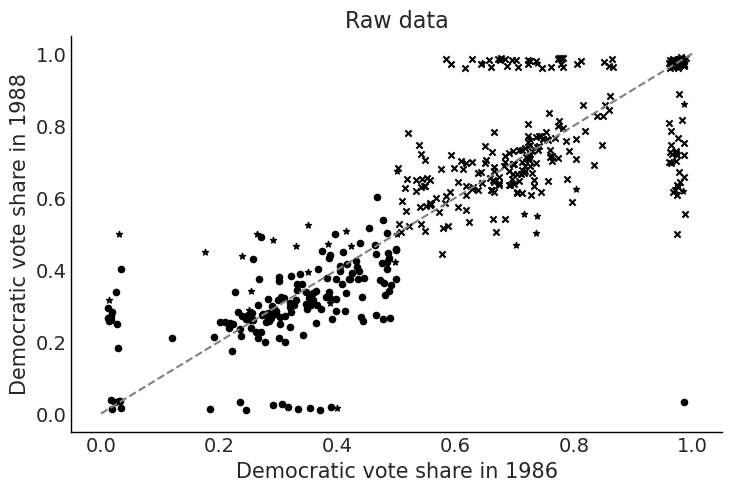

In [126]:
def jitt(vote):
    n = len(vote)
    return np.where(
        vote < 0.1,
        rng.uniform(0.01, 0.04, n),
        np.where(vote > 0.9, rng.uniform(0.96, 0.99, n), vote),
    )


j_v86 = jitt(congress["v86"])
j_v88 = jitt(congress["v88"])

fig, ax = plt.subplots()
ax.scatter(
    j_v86[congress["inc88"] == 0],
    j_v88[congress["inc88"] == 0],
    marker="*",
    c="black",
    s=20,
)
ax.scatter(
    j_v86[congress["inc88"] == 1],
    j_v88[congress["inc88"] == 1],
    marker="x",
    c="black",
    s=20,
)
ax.scatter(
    j_v86[congress["inc88"] == -1],
    j_v88[congress["inc88"] == -1],
    marker="o",
    c="black",
    s=20,
)
ax.plot([0, 1], [0, 1], color="gray", linestyle="--")

ax.set_title("Raw data")
ax.set_xlabel("Democratic vote share in 1986")
ax.set_ylabel("Democratic vote share in 1988")

Text(0.5, 1.0, 'Adjusted data')

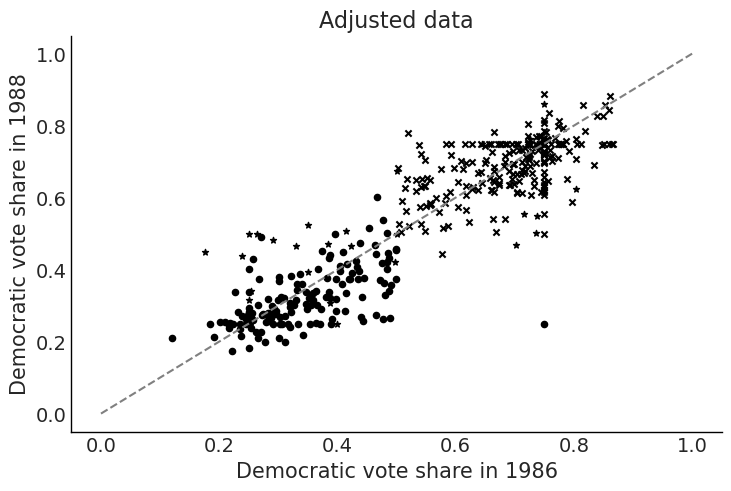

In [133]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], color="gray", linestyle="--")
ax.set_xlabel("Democratic vote share in 1986")
ax.set_ylabel("Democratic vote share in 1988")
ax.scatter(
    congress["v86_adj"][congress["inc88"] == 0],
    congress["v88_adj"][congress["inc88"] == 0],
    marker="*",
    c="black",
    s=20,
)
ax.scatter(
    congress["v86_adj"][congress["inc88"] == 1],
    congress["v88_adj"][congress["inc88"] == 1],
    marker="x",
    c="black",
    s=20,
)
ax.scatter(
    congress["v86_adj"][congress["inc88"] == -1],
    congress["v88_adj"][congress["inc88"] == -1],
    marker="o",
    c="black",
    s=20,
)
ax.set_title("Adjusted data")